In [25]:
import os
os.chdir('/Users/nilssturma/git/multi-domain-crl/')
os.getcwd()

'/Users/nilssturma/git/multi-domain-crl'

In [26]:
# === IMPORTS: BUILT-IN ===
import pickle
#from time import time

# === IMPORTS: THIRD-PARTY ===
import numpy as np
from scipy.stats import beta, expon, lognorm, weibull_min, chi2, gumbel_r, skewnorm

# === IMPORTS: LOCAL ===
from src.learner import LinearMDCRL
from experiments.rand import rand_model

## Define model

In [27]:
n=5000
measure = "ks-test"

rvs = [beta(2,3), beta(2,5), chi2(df=4), gumbel_r, lognorm(s=1),
    weibull_min(c=2), expon(scale=0.1), skewnorm(a=6), skewnorm(a=12)]

In [28]:
m = {
    "nr_doms": 2,
    "joint_idx": [0,1,2],
    "domain_spec_idx": [[3,4],[5,6]],
    "noise_rvs": rvs,
    "sample_sizes":  [5000,5000],
    "dims": [15,15],
    "graph_density": 0.75,
    "mixing_density": 0.9,
    "mixing_distribution": 'unif',  # unif or normal
    "two_pure_children": True
}


## Sample data

In [29]:
m["sample_sizes"] = [n for _ in range(m["nr_doms"])]
data, g, B_true = rand_model(m)
A_true = np.transpose(g.to_amat())

## Fit model

In [30]:
model = LinearMDCRL(measure=measure, gamma=0.1)
model.fit(data)

In [31]:
model.joint_mixing.round(2)

array([[-0.58, -0.57, -0.36,  0.82, -0.32,  0.  ,  0.  ],
       [-1.03, -0.48,  0.47, -0.05, -0.82,  0.  ,  0.  ],
       [ 0.65,  0.03,  0.  , -0.84,  0.61,  0.  ,  0.  ],
       [ 0.76, -0.67, -1.39, -0.97, -0.71,  0.  ,  0.  ],
       [ 1.64, -0.93, -1.  ,  0.01, -0.68,  0.  ,  0.  ],
       [-0.61,  0.92,  0.18,  0.95, -0.37,  0.  ,  0.  ],
       [ 0.41, -0.34, -0.75,  0.74,  0.34,  0.  ,  0.  ],
       [-0.23,  0.75, -0.07, -0.63,  0.32,  0.  ,  0.  ],
       [-0.34,  0.02,  0.34, -0.01,  0.01,  0.  ,  0.  ],
       [ 0.5 ,  0.58, -0.55, -0.81,  0.75,  0.  ,  0.  ],
       [-0.02, -0.98, -0.38, -0.79,  0.84,  0.  ,  0.  ],
       [-0.26,  0.32,  0.23,  0.73,  0.78,  0.  ,  0.  ],
       [-1.4 ,  0.68,  0.96,  0.93, -0.45,  0.  ,  0.  ],
       [ 1.46, -0.73, -1.11,  0.01,  0.36,  0.  ,  0.  ],
       [-1.34,  0.41,  0.53, -0.01, -0.68,  0.  ,  0.  ],
       [ 0.77, -0.01, -0.35,  0.  ,  0.  ,  0.84,  0.46],
       [-0.76, -0.8 ,  0.4 ,  0.  ,  0.  , -0.29,  0.4 ],
       [-0.  ,

In [33]:
model.joint_factors

[[1, 3], [2, 0], [4, 4]]

In [34]:
model.joint_signs

[[1, 1], [1, 1], [1, 1]]

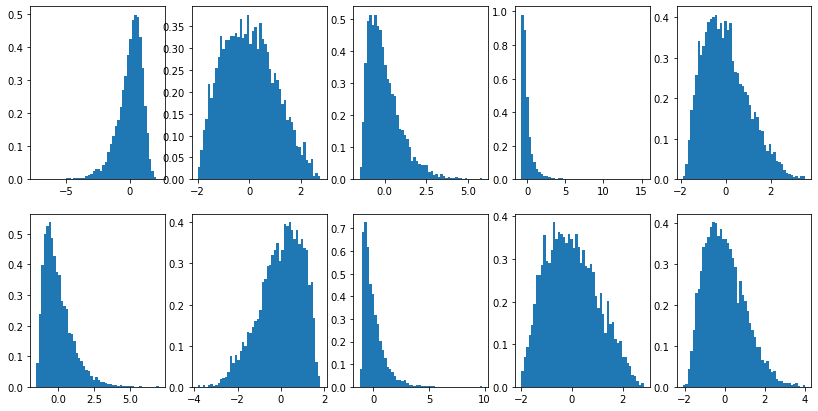

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(14, 7))

for i in range(2):
    for j in range(5):
        ax[i,j].hist(model.indep_comps[i][:,j], bins=50, density=True)

plt.show()

## Sample from joint distribution

In [36]:
indep_comps_large = []

# Shared components
for i,f in enumerate(model.joint_factors):
    shared_comp = np.array([])
    for env in range(model.nr_env):
        shared_comp = np.concatenate((shared_comp, 
                                      (model.joint_signs[i][env] * model.indep_comps[env][:,f[env]])))
    indep_comps_large.append(shared_comp)
    
# Domain-specific components
for env in range(model.nr_env):
    ncomps = model.indep_comps[env].shape[1]
    shared_components = [f[env] for f in model.joint_factors]
    dom_spec_comps = set(np.arange(ncomps)) - set(shared_components)
    for comp in dom_spec_comps:
        indep_comps_large.append(model.indep_comps[env][:,comp])
        
# This should define a function "get_components"

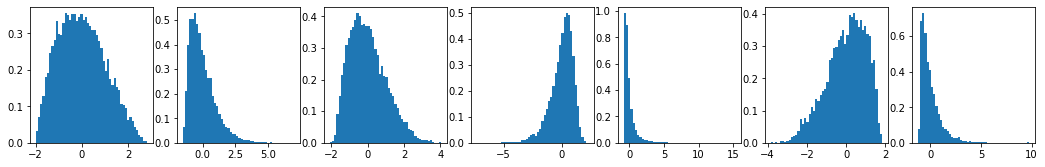

In [37]:
fig, ax = plt.subplots(1, 7, figsize=(18, 2.5))

for j in range(7):
    ax[j].hist(indep_comps_large[j], bins=50, density=True)

plt.show()

In [38]:
def sample_from_joint_distr(size=5000):
    noise_mat = np.zeros((size, model.total_nr_lat))
    for comp in range(model.total_nr_lat):
        noise_mat[:,comp] = np.random.choice(indep_comps_large[comp], size = size, replace=True)
        
    samples = np.transpose(np.matmul(model.joint_mixing, np.transpose(noise_mat)))
    
    return(samples)

In [39]:
samples = sample_from_joint_distr()

## Apply LaHME on samples from joint distribution

In [42]:
os.chdir('/Users/nilssturma/git/multi-domain-crl/code_for_LaHME')
from Main_LiNGLaH_LaHME import LaHME
import pandas as pd
import time
time.clock = time.time  # The LaHME code uses time.clock which is deprecated

In [43]:
df = pd.DataFrame(samples)

In [ ]:
LaHME(df)  ### This is toooo slow, cannot do simulations! (Did not finish after several hours!)